In [1]:
import tqdm
import numpy as np
import scipy.stats
import pandas as pd
import sklearn
import sklearn.covariance
import networkx as nx
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('ticks')
palette = sns.color_palette("RdBu_r", n_colors=25)

import kliep

## Company trend

In [2]:
df = pd.read_csv('data/agfam.csv')
df = df.drop(['Week'], axis=1)
df = (df - df.mean()) / df.std()
X = df.values
df[:5]

,Apple,Google,Facebook,Amazon,Microsoft
0,0.920398,0.619629,-0.497073,-1.094401,-0.457035
1,0.191342,-0.156953,-0.835368,-1.094401,-0.457035
2,0.312852,-1.030608,-0.666220,-1.094401,-0.457035
3,0.312852,1.299139,-0.609838,-0.371265,0.251596
4,2.013982,-0.059880,-0.553455,1.798142,0.960226


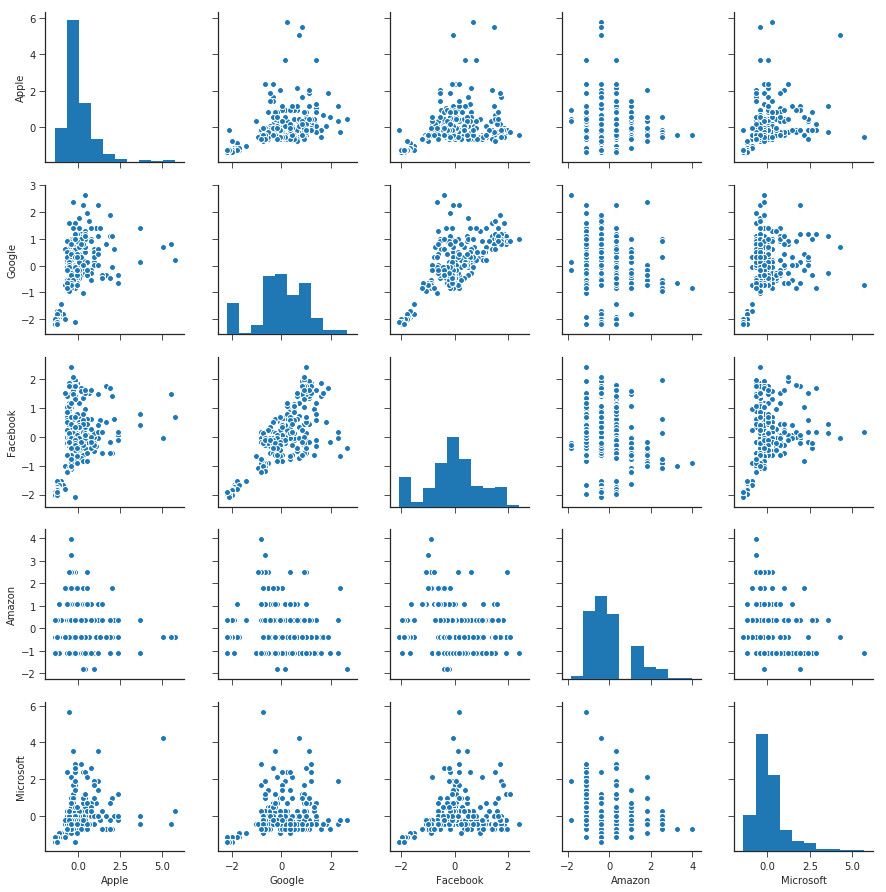

In [3]:
sns.pairplot(data=df)

In [4]:
model = sklearn.covariance.GraphLasso(alpha=0.3)
model.fit(X)

GraphLasso(alpha=0.3, assume_centered=False, enet_tol=0.0001, max_iter=100,
      mode='cd', tol=0.0001, verbose=False)

In [5]:
d = 5
mi = np.zeros([d, d])
cmi = np.zeros([d, d])
for i, j in tqdm.tqdm([(i, j) for i in range(d) for j in range(d) if i > j]):
    mi[i, j] = mi[j, i] = kliep.mutual_information_kliep(X=X[:, i].reshape(-1, 1), Y=X[:, j].reshape(-1, 1), maxiter=1000)
    mask = (np.arange(d) != i) & (np.arange(d) != j)
    mi_xz = kliep.mutual_information_kliep(X=X[:, i].reshape(-1, 1), Y=X[:, mask], maxiter=1000)
    mi_yz = kliep.mutual_information_kliep(X=X[:, j].reshape(-1, 1), Y=X[:, mask], maxiter=1000)
    mi_xyz = kliep.mutual_information_kliep(X=X[:, i].reshape(-1, 1), Y=X[:, j].reshape(-1, 1), Z=X[:, mask], maxiter=1000)
    cmi[i, j] = cmi[j, i] = mi_xyz - (mi_xz + mi_yz)

cmi[cmi < 0] = 0

100%|██████████| 10/10 [00:41<00:00,  4.23s/it]


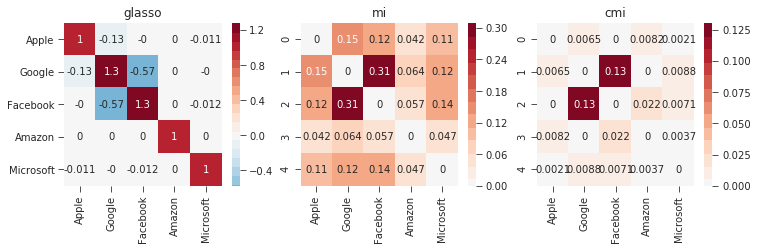

In [6]:
f, axes = plt.subplots(1, 3, figsize=[12, 3])
axes[0].set_title('glasso')
axes[1].set_title('mi')
axes[2].set_title('cmi')
sns.heatmap(model.precision_, annot=True, ax=axes[0], center=0, xticklabels=list(df.columns), yticklabels=list(df.columns), cmap=palette)
sns.heatmap(mi, annot=True, ax=axes[1], center=0, xticklabels=list(df.columns), cmap=palette)
sns.heatmap(cmi, annot=True, ax=axes[2], center=0, xticklabels=list(df.columns), cmap=palette)

## Buzz words

In [7]:
df = pd.read_csv('data/buzz-words.csv')
df = df.drop(['Week'], axis=1)
df = (df - df.mean()) / df.std()
X = df.values
df[:5]

,Artificial Intelligence: (Worldwide),Machine Learning: (Worldwide),Deep Learning: (Worldwide),Big Data: (Worldwide),Internet of things: (Worldwide)
0,-0.803415,-0.396749,-1.138164,-0.277719,-0.890616
1,-1.006802,-0.632094,-1.138164,-0.534757,-0.890616
2,-0.803415,-0.632094,-1.138164,-0.791795,-0.890616
3,-0.803415,-0.161405,-1.138164,-0.149200,-0.890616
4,-0.600029,-0.632094,-1.138164,-0.406238,-0.890616


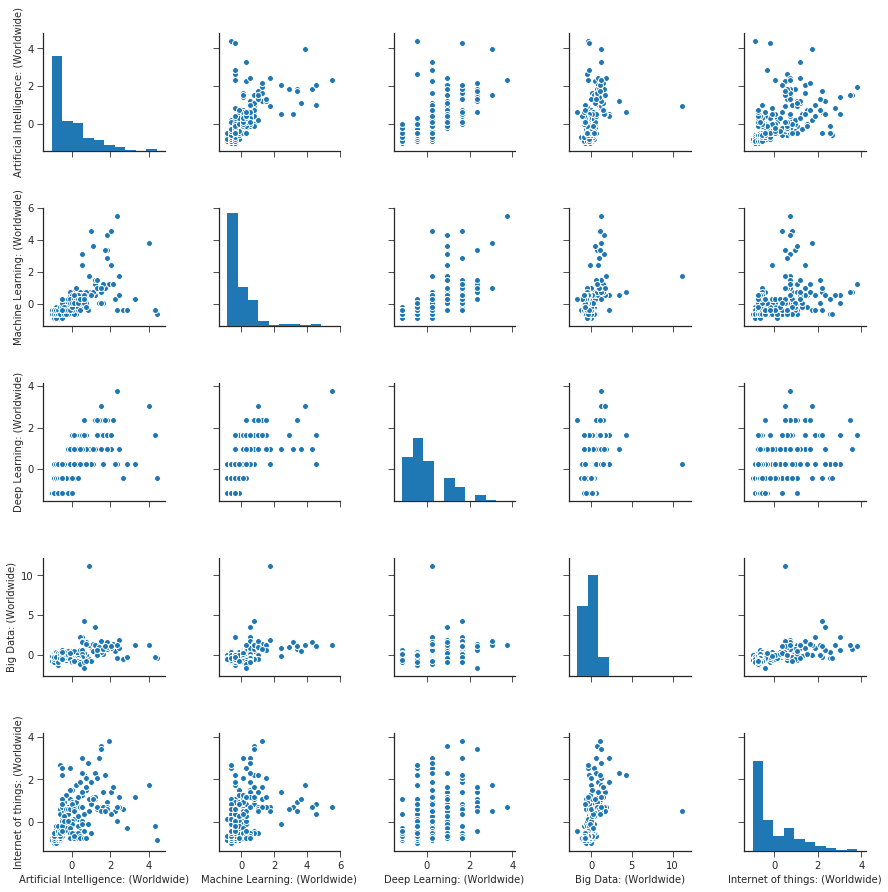

In [8]:
sns.pairplot(data=df)

In [9]:
# model = sklearn.covariance.GraphLassoCV(alphas=[0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8])
model = sklearn.covariance.GraphLasso(alpha=0.5, assume_centered=True)
model.fit(df.values)

GraphLasso(alpha=0.5, assume_centered=True, enet_tol=0.0001, max_iter=100,
      mode='cd', tol=0.0001, verbose=False)

In [10]:
d = 5
mi = np.zeros([d, d])
cmi = np.zeros([d, d])
for i, j in tqdm.tqdm([(i, j) for i in range(d) for j in range(d) if i > j]):
    mi[i, j] = mi[j, i] = kliep.mutual_information_kliep(X=X[:, i].reshape(-1, 1), Y=X[:, j].reshape(-1, 1), maxiter=1000)
    mask = (np.arange(d) != i) & (np.arange(d) != j)
    mi_xz = kliep.mutual_information_kliep(X=X[:, i].reshape(-1, 1), Y=X[:, mask], maxiter=1000)
    mi_yz = kliep.mutual_information_kliep(X=X[:, j].reshape(-1, 1), Y=X[:, mask], maxiter=1000)
    mi_xyz = kliep.mutual_information_kliep(X=X[:, i].reshape(-1, 1), Y=X[:, j].reshape(-1, 1), Z=X[:, mask], maxiter=1000)
    cmi[i, j] = cmi[j, i] = mi_xyz - (mi_xz + mi_yz)

cmi[cmi < 0] = 0

100%|██████████| 10/10 [00:43<00:00,  4.45s/it]


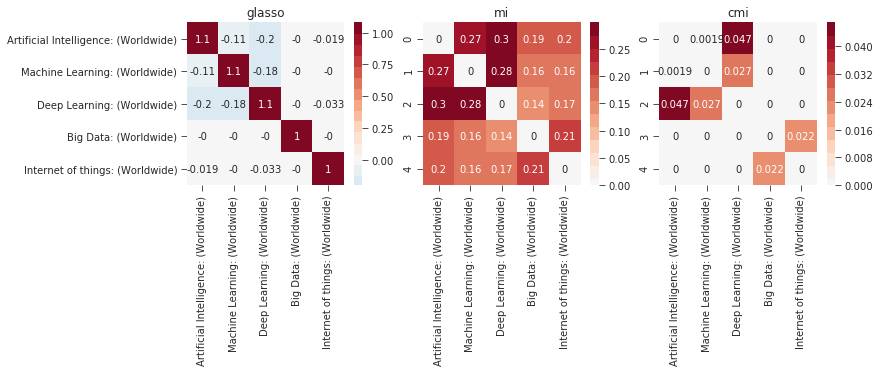

In [11]:
f, axes = plt.subplots(1, 3, figsize=[12, 3])
axes[0].set_title('glasso')
axes[1].set_title('mi')
axes[2].set_title('cmi')
sns.heatmap(model.precision_, annot=True, ax=axes[0], center=0, xticklabels=list(df.columns), yticklabels=list(df.columns), cmap=palette)
sns.heatmap(mi, annot=True, ax=axes[1], center=0, xticklabels=list(df.columns), cmap=palette)
sns.heatmap(cmi, annot=True, ax=axes[2], center=0, xticklabels=list(df.columns), cmap=palette)

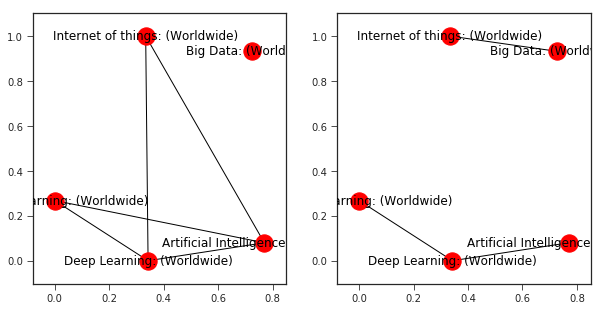

In [12]:
g1 = nx.from_numpy_matrix(model.precision_)
g2 = nx.from_numpy_matrix(cmi > 0.02)
pos = nx.spring_layout(g1)
pos = nx.spring_layout(g2)

plt.subplots(1, 2, figsize=[10, 5])
plt.subplot(1, 2, 1)
nx.draw_networkx(g1, pos=pos, with_labels=False)
nx.draw_networkx_labels(g1, pos, dict(enumerate(df.columns)))
plt.subplot(1, 2, 2)
nx.draw_networkx(g2, pos=pos, with_labels=False)
nx.draw_networkx_labels(g2, pos, dict(enumerate(df.columns)))
plt.show()